In [7]:
# set parameters
# import colors for plots
import matplotlib.colors as mcolors
colors = list(mcolors.TABLEAU_COLORS)


# import functions

import scipy.io as sio

import numpy as np
import scipy

import torch.nn as nn
import torch.utils.data as torchdata
import torch

import importlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from scipy.stats import entropy

from numpy import random

from copy import deepcopy

from openpyxl import load_workbook

import novosparc
import anndata as ad
import scanpy as sc
import pandas as pd

import json

In [5]:
import sys
sys.path.append("./src")

In [8]:
# import RNAupdate
from RNAupdate import dataset_gen
from RNAupdate import sudo_algo2
from RNAupdate import encoder
from RNAupdate import helper
from RNAupdate import novo_weight

In [40]:
import os.path as path

root =  path.abspath(path.join('.', '../..'))

In [50]:
folder_path = root + '/Code-to-upload/data/intestine/'
dataset_path =folder_path + 'dge.tsv.gz'
target_space_path = folder_path + 'zones.tsv'

In [52]:
# cell by gene
# returns which gene has all 0 cell value
def filter_cell(data_mat):
    return np.where(~data_mat.any(axis = 0))[0]
def num_zero_gene(data_mat):
    return np.sum([data_mat == 0][0], axis = 0)

# read from file 
def read_dic(f_name):
    return json.load(open(f_name))

In [53]:
# this is cell by gene
dataset = novosparc.io.load_data(dataset_path).T

# normalize
sc.pp.normalize_total(dataset, target_sum=1, inplace=True)
# sc.pp.log1p(dataset)
data_mat = dataset.X

In [54]:
# find cell's location label ((tsne position), layer label)
locations_original = np.loadtxt(target_space_path, skiprows=1, usecols=range(1, 4))
locations_original = locations_original[:, 2]
# grid_len = len(np.unique(locations_original))
# locations = np.vstack((range(grid_len), np.ones(grid_len))).T

loc_dic = {}
for i in np.unique(locations_original):
    loc_dic[i] = [locations_original == i]

In [56]:
# read zonated genes
df = pd.read_excel(folder_path + 'mmc1.xlsx', sheet_name='table_S1_clusters')
z_gene_mat = df.to_numpy()
z_gene_dic = {}
for i in range(5):
    cur_z = z_gene_mat[:, i].astype(str)
    z_gene_dic[i] = cur_z[cur_z != 'nan']


In [57]:
# read all zonated genes
all_z_dic = pd.read_csv(folder_path + 'table_D_zonation_reconstruction.tsv', sep='\t')

In [64]:
# read all types of genes 
gene_names = np.array(all_z_dic['Gene name']).astype(str)
q_val = np.array(all_z_dic['qval']).astype(float)
all_z_genes = [str(gene_names[i]) for i in range(len(gene_names)) if q_val[i] <= 0.05]
z_gene = np.concatenate([z_gene_dic[i] for i in z_gene_dic], axis = 0)
other_z = [g for g in all_z_genes if g not in z_gene]

In [61]:
len(other_z) + len(z_gene) - len(all_z_genes)

51

In [78]:
# get total list of genes 
gene_list = dataset.var_names.astype(str)
other_z = [g for g in all_z_genes if g not in z_gene]
other_gene = [g for g in gene_list if (g not in z_gene) and (g not in other_z)]
# sorted genes list
total_gene = list(z_gene) + other_z + other_gene
# store the number of zonated genes
l_z = len(z_gene) + len(other_z)

In [82]:
num_cell, num_gene = data_mat.shape

In [80]:
# get top 1000 high variance genes
var_genes = np.argsort([helper.coef_std(data_mat[:, i]) for i in range(num_gene)])
var_genes1000 = np.sort(var_genes[-1000:])
z_var_genes = [gene_list[i] for i in var_genes1000 if gene_list[i] in z_gene]
z_var_genes2 = [gene_list[i] for i in var_genes1000 if gene_list[i] in other_z]
other_var = [gene_list[i] for i in var_genes1000 if gene_list[i] in other_gene]
var_genes1000 = z_var_genes + z_var_genes2 + other_var
l_z = len(z_var_genes)

In [84]:
mean_gene_exp = helper.compute_mean_gene_exp(data_mat, loc_dic)
mean_gene_ann = sc.AnnData(pd.DataFrame(mean_gene_exp,columns=gene_list), dtype=mean_gene_exp.dtype)

/n/home05/ysheng/.conda/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [92]:
# function to computep correlation coefficients given a a tissue object
def find_coef(tissue_dic, gene_list, dataset, dim, flip_list, mean_gene_ann):
    res_coef_list = []
    
    for t in tissue_dic:
        cell_map = tissue_dic[t].gw * dim
        cur_coef = []
        #     t = 0
        for g in gene_list:
            temp = dataset[:, g].X.T.dot(cell_map).T
            
            temp2 = np.array([np.mean(temp[int(i * (dim/7)): int((i + 1)* (dim/7))]) for i in range(7)])
#             print(temp2)
            if t in flip_list:
                temp2 = np.flip(temp2)
            coef = np.corrcoef(mean_gene_ann[:, g].X.T[0], temp2)[0][1]
            cur_coef.append(coef)
            
        res_coef_list.append(cur_coef)
    return res_coef_list
# coef_dic[t] = cur_coef



In [310]:
reload()
# get data for high variance genes as training data and normalize
filtered_data = dataset[:, var_genes1000].copy()
filtered_data.X = filtered_data.X * 1e5
sc.pp.log1p(filtered_data)
filtered_data.X = dataset_gen.normalized_row_nan(filtered_data.X.T).T

print('num_cell, num_gene = ' + str(filtered_data.X.shape))

# data_norm = sc.AnnData(pd.DataFrame(data_mat.T,columns=var_genes), dtype=data_mat.dtype)
l_v = len(var_genes1000)
init_weight = np.array([1/l_v] * l_v)
# init_weight = np.array([1/l_z] * l_z + [0] * (l_v - l_z))
dim = 14
n_s = 5
n_t = 4
eps = 5e-3
num_itr = 20
lamb = 0.5
update_tiss = novo_weight.multi_weight_novo_param(init_weight, filtered_data, num_itr, dim, n_s, n_t, eps, lamb)

num_cell, num_gene = (1383, 1000)
cur itr is 0 training with weight 
Setting up for reconstruction ... done ( 1.02 seconds )
Reconstructing spatial information with 0 markers: 1383 cells and 14 locations ... 
Trying with epsilon: 5.00e-03
cur itr is 1 training with weight 
Setting up for reconstruction ... done ( 0.83 seconds )
Reconstructing spatial information with 0 markers: 1383 cells and 14 locations ... 
Trying with epsilon: 5.00e-03
cur itr is 2 training with weight 
Setting up for reconstruction ... done ( 0.78 seconds )
Reconstructing spatial information with 0 markers: 1383 cells and 14 locations ... 
Trying with epsilon: 5.00e-03
cur itr is 3 training with weight 
Setting up for reconstruction ... done ( 0.77 seconds )
Reconstructing spatial information with 0 markers: 1383 cells and 14 locations ... 
Trying with epsilon: 5.00e-03
cur itr is 4 training with weight 
Setting up for reconstruction ... done ( 0.77 seconds )
Reconstructing spatial information with 0 markers: 1383

In [129]:
# get data for high variance genes as training data and normalize
filtered_data = dataset[:, var_genes1000].copy()
filtered_data.X = filtered_data.X * 1e5
sc.pp.log1p(filtered_data)
filtered_data.X = dataset_gen.normalized_row_nan(filtered_data.X.T).T

print('num_cell, num_gene = ' + str(filtered_data.X.shape))

# data_norm = sc.AnnData(pd.DataFrame(data_mat.T,columns=var_genes), dtype=data_mat.dtype)
l_v = len(var_genes1000)
l_z = len(z_var_genes)
init_weight = np.array([1/l_z] * l_z + [0] * (l_v - l_z))
dim = 14
n_s = 5
n_t = 4
eps = 5e-3
num_itr = 1
lamb = 0.5
update_tiss_z = novo_weight.multi_weight_novo_param(init_weight, filtered_data, num_itr, dim, n_s, n_t, eps, lamb)

num_cell, num_gene = (1383, 1000)
cur itr is 0 training with weight 
Setting up for reconstruction ... done ( 1.0 seconds )
Reconstructing spatial information with 0 markers: 1383 cells and 14 locations ... 
Trying with epsilon: 5.00e-03


In [110]:
# compute the correlation coefficients 
coef= find_coef(update_tiss[0], total_gene, dataset, dim, [0, 1, 2, 3, 5, 6], mean_gene_ann)
# with open(root + '/Code-to-upload/output/coef_novo_hvg.txt', 'w') as convert_file:
#      convert_file.write(json.dumps(coef))

/n/home05/ysheng/.conda/envs/torch/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


In [134]:
coef_z = find_coef(update_tiss_z[0], total_gene, dataset, dim, [], mean_gene_ann)
# with open(root + '/Code-to-upload/output/coef_novo_z_hvg.txt', 'w') as convert_file:
#      convert_file.write(json.dumps(coef_z))

/n/home05/ysheng/.conda/envs/torch/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


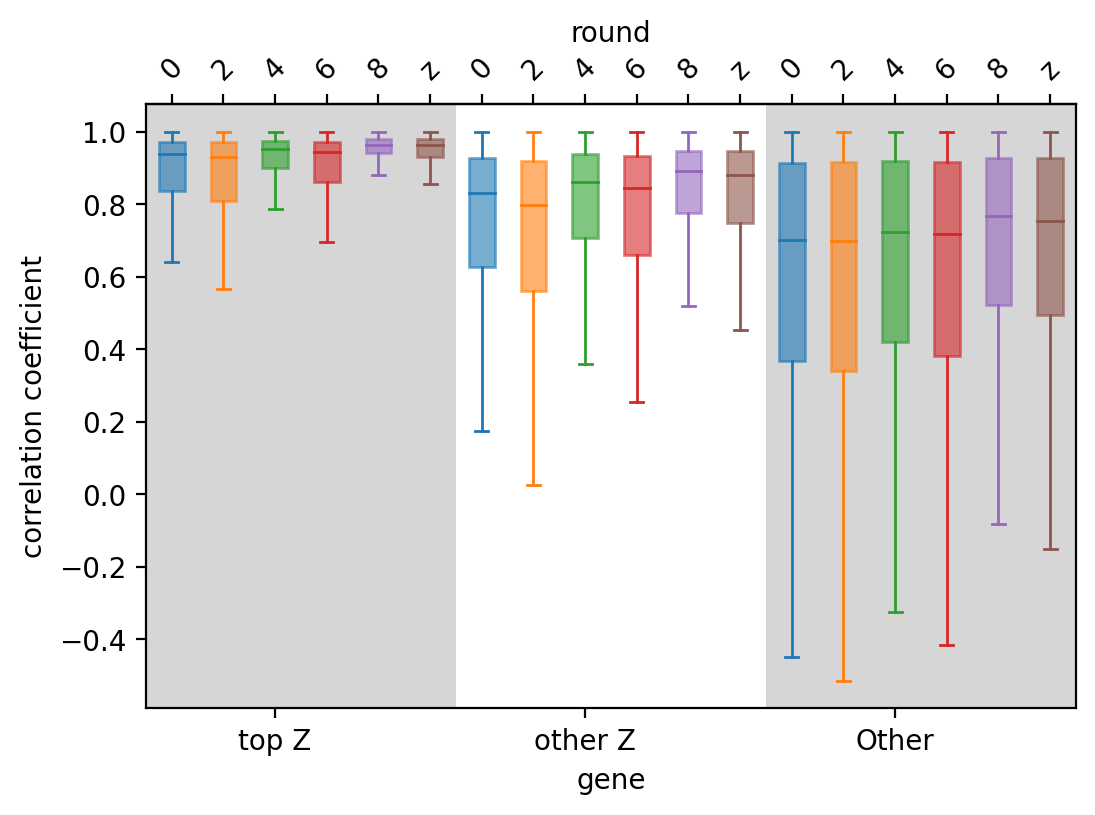

In [142]:
# generate plot for correlation coefficients
fig, ax = plt.subplots()
l_z = len(z_gene) + len(other_z)
index = [0,2, 4, 6, 8]
data = {}
for n in index:
    cur_coef = np.array(coef[n])[~np.isnan(coef[n])]
    
    data[n] = [cur_coef[0:1000], cur_coef[1000:l_z], cur_coef[l_z:]]
#     print(data[n][-1])
# add data for when only trained on zonated genes
cur_coef = np.array(coef_z[0])[~np.isnan(coef_z[0])]
data['z'] = [cur_coef[0:1000], cur_coef[1000:l_z], cur_coef[l_z:]]
t = 0
for n in data:
    pos = t - int(len(index)/2)
    ax.boxplot(data[n],positions=np.array(range(3))*(len(index) + 1)+  pos, showfliers = False, patch_artist=True, boxprops=dict(facecolor=colors[t], color=colors[t], alpha=0.6), medianprops=dict(color=colors[t]), capprops=dict(color=colors[t]), whiskerprops=dict(color=colors[t]))
    t += 1

ticks = ['top Z', 'other Z', 'Other']
plt.xticks(range(0, len(ticks) * (len(index) + 1) - 3, 6), ticks)
plt.xlim(-2.5, len(ticks)*6-2.5)

# bp4 = ax.boxplot(np.concatenate([mi_t[t][50:] for t in range(4)], axis = 1), showfliers = False, patch_artist=True, boxprops=dict(color=colors[3], facecolor=colors[3], alpha = 0.6), medianprops=dict(color=colors[3]), capprops=dict(color=colors[3]), whiskerprops=dict(color=colors[3]))
# ax.legend([bp3["boxes"][0], bp5["boxes"][0]], ['10 round update', 'no update'], loc='lower right')
ax.set_ylabel('correlation coefficient')
ax.set_xlabel('gene')

secx = ax.secondary_xaxis('top')
secx.set_xticks([i - 2 for i in range((len(index) + 1) * 3)])
secx.set_xticklabels((index + ['z']) * 3,  rotation = 45)
secx.set_xlabel('round')
for i in range(2):
    plt.axvspan(-2.5 + i * 12, 3.5 + i * 12, facecolor='0.2', alpha=0.2)




In [419]:
filtered_data = dataset[:, var_genes1000].copy()
filtered_data.X = filtered_data.X * 1e5
sc.pp.log1p(filtered_data)
filtered_data.X = dataset_gen.normalized_row_nan(filtered_data.X.T).T
output_mat = filtered_data.X.T

data_dim, cell_dim = output_mat.shape

codes_dic = {}
index =[0, 2, 4, 6, 8, 10] 
for i in index:
    max_epoch = 70
    code_dim = 1
    hidden_layers = [32, 8]
    # hidden_layers = [16, 8]
    step_size = 0.1
    num_iter = i
    algo_output = sudo_algo2.run_exp(output_mat, max_epoch, code_dim, hidden_layers, step_size, num_iter, act_fn, data_dim)
    
    codes = helper.get_encoder(algo_output[0], output_mat)
    shifted_codes = helper.shift(codes, 'none')
    codes_dic[i] = shifted_codes



training with data-dim: 1000max epoch: 70code-dim: 1dimension of hidden layers are: [32, 8]step-size: 0.1
num sample is 20
cur iteration is 0
1244
{'input_shape': 1000, 'code_dim': 1, 'list_dim': [32, 8], 'act_fn': 'tanh'}
1.0
training with data-dim: 1000max epoch: 70code-dim: 1dimension of hidden layers are: [32, 8]step-size: 0.1
num sample is 20
cur iteration is 0
1244
{'input_shape': 1000, 'code_dim': 1, 'list_dim': [32, 8], 'act_fn': 'tanh'}
1.0
cur iteration is 1
1244
{'input_shape': 1000, 'code_dim': 1, 'list_dim': [32, 8], 'act_fn': 'tanh'}
1.0
cur iteration is 2
1244
{'input_shape': 1000, 'code_dim': 1, 'list_dim': [32, 8], 'act_fn': 'tanh'}
0.9999999999999998
training with data-dim: 1000max epoch: 70code-dim: 1dimension of hidden layers are: [32, 8]step-size: 0.1
num sample is 20
cur iteration is 0
1244
{'input_shape': 1000, 'code_dim': 1, 'list_dim': [32, 8], 'act_fn': 'tanh'}
0.9999999999999998
cur iteration is 1
1244
{'input_shape': 1000, 'code_dim': 1, 'list_dim': [32, 8],

In [413]:
filtered_data = dataset[:, var_genes1000].copy()
filtered_data.X = filtered_data.X * 1e5
sc.pp.log1p(filtered_data)
filtered_data.X = dataset_gen.normalized_row_nan(filtered_data.X.T).T
output_mat = filtered_data.X.T

data_dim, cell_dim = output_mat.shape


codes_dic_z = {}

max_epoch = 120
code_dim = 1
hidden_layers = [32, 8]
    # hidden_layers = [16, 8]
step_size = 0.1
num_iter = 0

l_z = len(z_var_genes)

algo_output = sudo_algo2.run_exp(output_mat, max_epoch, code_dim, hidden_layers, step_size, num_iter, act_fn, l_z)
    
codes = helper.get_encoder(algo_output[0], output_mat)
shifted_codes = helper.shift(codes, 'none')
codes_dic_z[0] = shifted_codes



training with data-dim: 1000max epoch: 120code-dim: 1dimension of hidden layers are: [32, 8]step-size: 0.1
num sample is 20
cur iteration is 0
1244
{'input_shape': 1000, 'code_dim': 1, 'list_dim': [32, 8], 'act_fn': 'tanh'}
1.0


In [193]:
# compute correlation coefficients from AE encoding 
def find_coef_ae(codes_dic, gene_list, dataset, flip_list, mean_gene_ann):
    res_coef_list = []
    
    for c in codes_dic:
        codes = codes_dic[c]
        cur_coef = []
        subsets = []
        for i in range(1, 8):
            low = np.max([0, i - 1])
            high = np.min([7, i + 2])
            subset = [codes >= low * 1/9][0] * [codes <= high * 1/9][0]
            subsets.append(subset)
        #     t = 0
        for g in gene_list:
            cur_g = dataset[:, g].X
#             print(cur_g.shape)
            temp = [np.array(cur_g)[s] for s in subsets]
            temp2 = []
            for cur in temp:
                if len(cur > 0):
                    temp2.append(np.sum(cur) * 1/len(cur))
                else:
        #             print(len(temp))
                    temp2.append(0)
            
#             print(temp2)
            if c in flip_list:
                temp2 = np.flip(temp2)
            
            coef = np.corrcoef(mean_gene_ann[:, g].X.T[0], temp2)[0][1]
#             helper.plot_vec([mean_gene_ann[:, g].X.T[0], temp2])
#             plt.show()
            cur_coef.append(coef)
            
        res_coef_list.append(cur_coef)
    return res_coef_list
# coef_dic[t] = cur_coef




In [246]:
# code_dic2 = res[-1]
coef_ae = find_coef_ae(codes_dic, total_gene, dataset, [0, 2], mean_gene_ann)
# with open(root + '/Code-to-upload/output/coef_AE_hvg.txt', 'w') as convert_file:
#      convert_file.write(json.dumps(coef_ae))

/n/home05/ysheng/.conda/envs/torch/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/n/home05/ysheng/.conda/envs/torch/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [295]:
coef_ae_z = find_coef_ae(codes_dic_z, total_gene, dataset, [], mean_gene_ann)
# with open(root + '/Code-to-upload/output/coef_AE_z_hvg.txt', 'w') as convert_file:
#      convert_file.write(json.dumps(coef_ae_z))

/n/home05/ysheng/.conda/envs/torch/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/n/home05/ysheng/.conda/envs/torch/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [297]:
coef_ae = read_dic(folder_path + '(32, 8) 70 epoch tanh hvg.txt')

In [298]:
coef_ae_z = read_dic(folder_path +'(32, 8) 120 epoch tanh z hvg.txt')
     

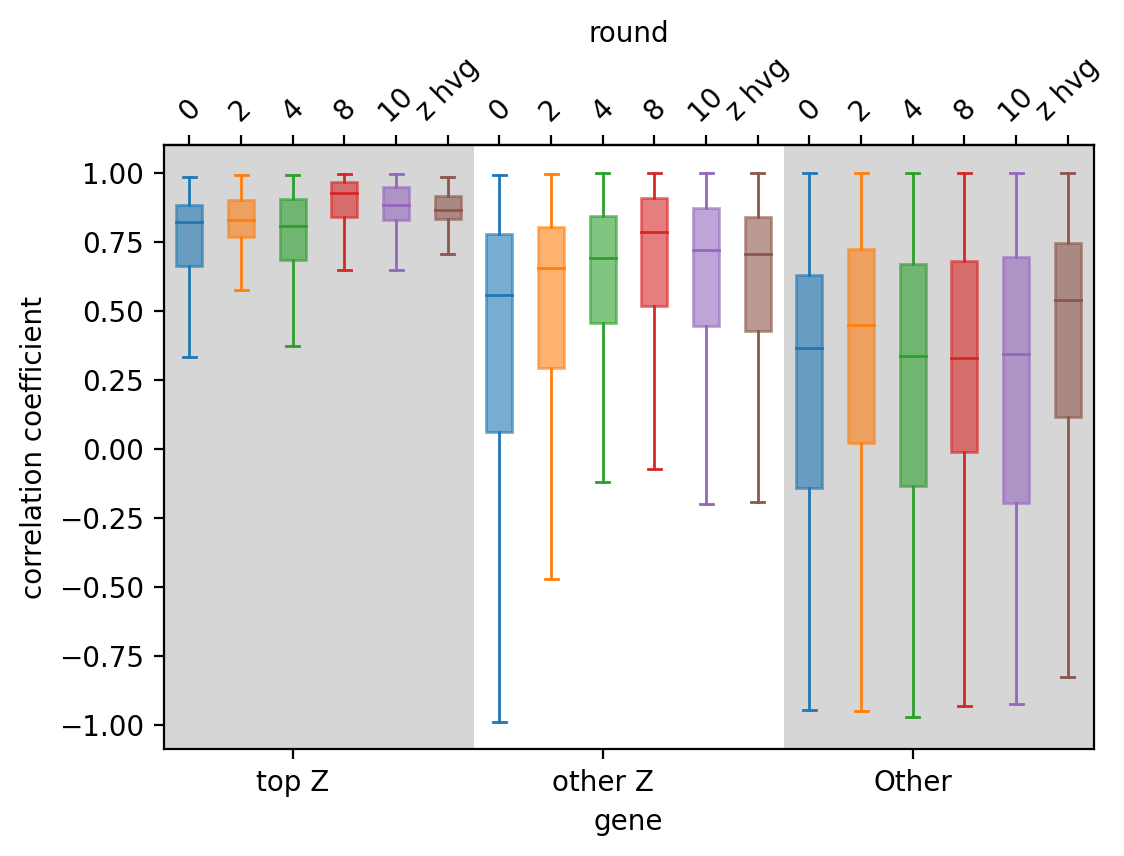

In [304]:
# on hvg 0
fig, ax = plt.subplots()
index = [i for i in range(5)]
data = {}
for n in index:
    cur_coef = np.array(coef_ae[n])[~np.isnan(coef_ae[n])]
    
    data[n] = [cur_coef[0:1000], cur_coef[1000:l_z], cur_coef[l_z:]]
#     print(data[n][-1])
cur_coef = np.array(coef_ae_z[0])[~np.isnan(coef_ae_z[0])]
data['z'] = [cur_coef[0:1000], cur_coef[1000:l_z], cur_coef[l_z:]]
t = 0
for n in data:
    pos = t - int(len(index)/2)
    ax.boxplot(data[n],positions=np.array(range(3))*(len(index) + 1)+  pos, showfliers = False, patch_artist=True, boxprops=dict(facecolor=colors[t], color=colors[t], alpha=0.6), medianprops=dict(color=colors[t]), capprops=dict(color=colors[t]), whiskerprops=dict(color=colors[t]))
    t += 1

ticks = ['top Z', 'other Z', 'Other']
plt.xticks(range(0, len(ticks) * (len(index) + 1) - 2, 6), ticks)
plt.xlim(-2.5, len(ticks)*6-2.5)

# bp4 = ax.boxplot(np.concatenate([mi_t[t][50:] for t in range(4)], axis = 1), showfliers = False, patch_artist=True, boxprops=dict(color=colors[3], facecolor=colors[3], alpha = 0.6), medianprops=dict(color=colors[3]), capprops=dict(color=colors[3]), whiskerprops=dict(color=colors[3]))
# ax.legend([bp3["boxes"][0], bp5["boxes"][0]], ['10 round update', 'no update'], loc='lower right')
ax.set_ylabel('correlation coefficient')
ax.set_xlabel('gene')


secx = ax.secondary_xaxis('top')
itr_list = [0, 2, 4, 8, 10]
secx.set_xticks([i - 2 for i in range(6 * 3)])
secx.set_xticklabels((itr_list + ['z hvg']) * 3,  rotation = 45)
secx.set_xlabel('round')

for i in range(2):
    plt.axvspan(-2.5 + i * 12, 3.5 + i * 12, facecolor='0.2', alpha=0.2)




/tmp/ipykernel_31688/3840437447.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  l = np.array(update_tiss[2])[[[0, 2, 4, 6, 8, 10]]]


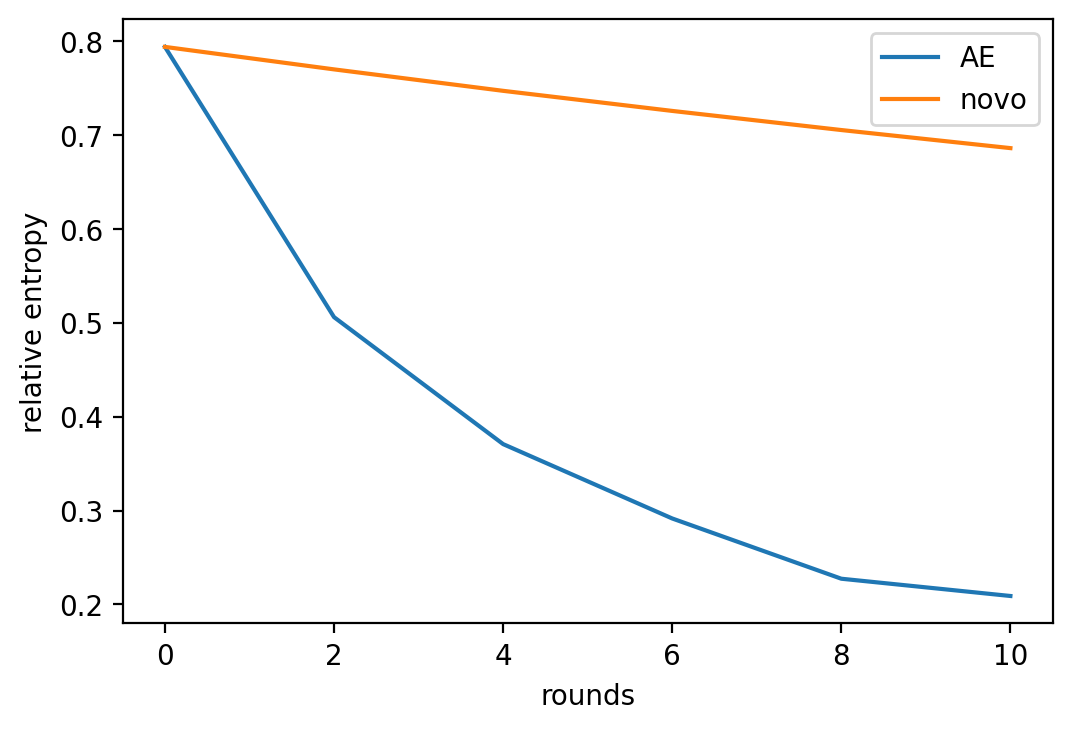

In [401]:
ticks = [0, 2, 4, 6, 8, 10]
l = np.array(algo_output[2])[[i - 1 for i in ticks[1:]]]
index = (algo_output[2][-1][0:l_z] > 0.001)
tru = np.array((index/np.sum(index)).tolist() + [0]*(l_v - l_z))
plt.plot([entropy(tru, init_weight)] + [entropy(tru, w) for w in l], label = 'AE')

l = np.array(update_tiss[2])[[[0, 2, 4, 6, 8, 10]]]
index = (update_tiss[2][-1][0:l_z] > 0.00095)
plt.plot([entropy(tru, w) for w in l], label = 'novo')

plt.xticks([i for i in range(6)], ticks)
plt.xlabel('rounds')
plt.ylabel('relative entropy')

plt.legend()

0.877541692713699
0.9091095042938717
0.8414310611005997


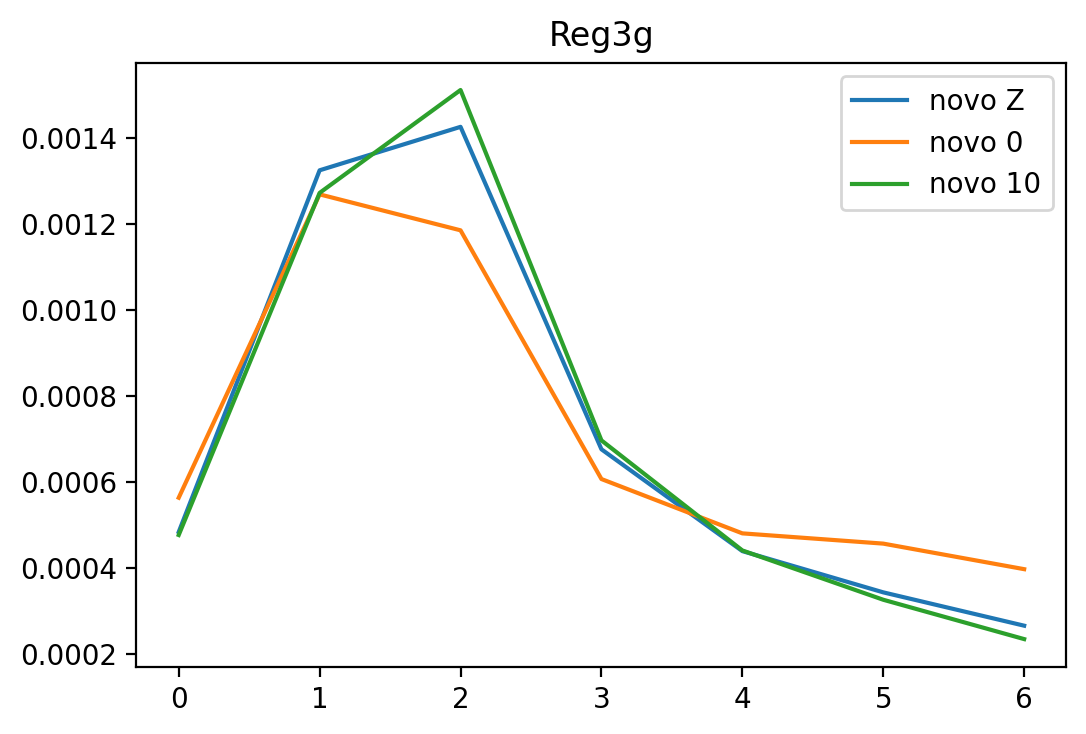

0.9680979205645668
0.9663068944049394
0.9706027240283942


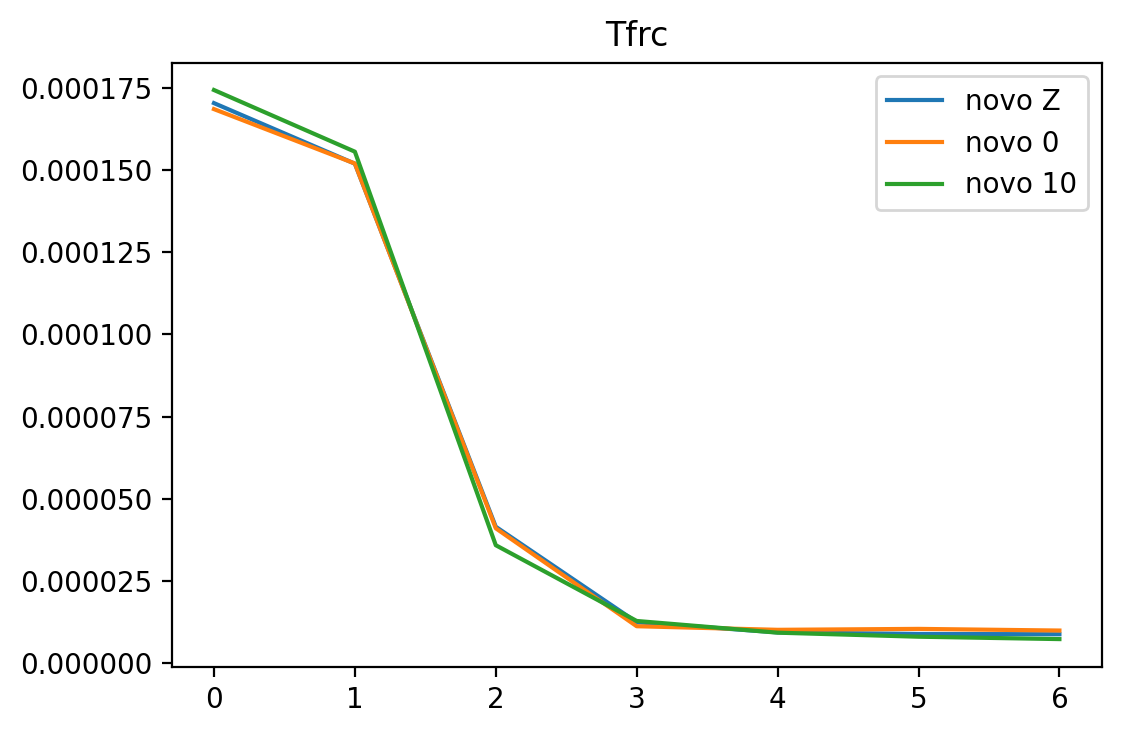

0.9630917037710885
0.7798976384710711
0.9701729886003844


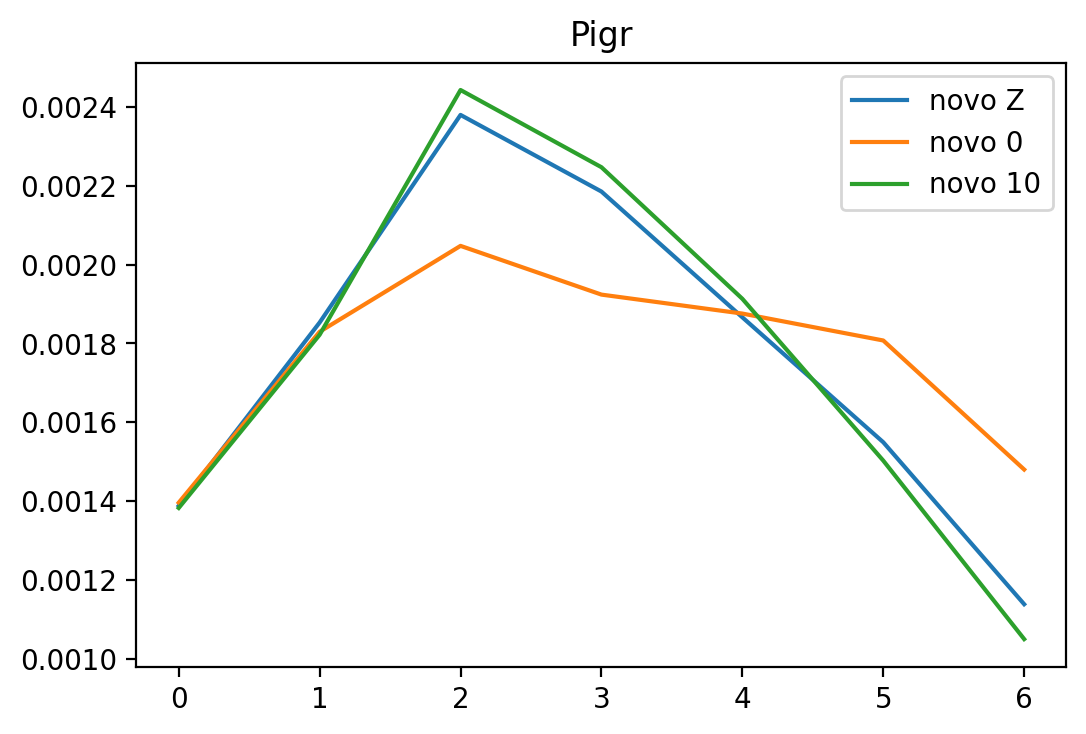

0.9168893449104828
0.8309329898698441
0.9280849749303783


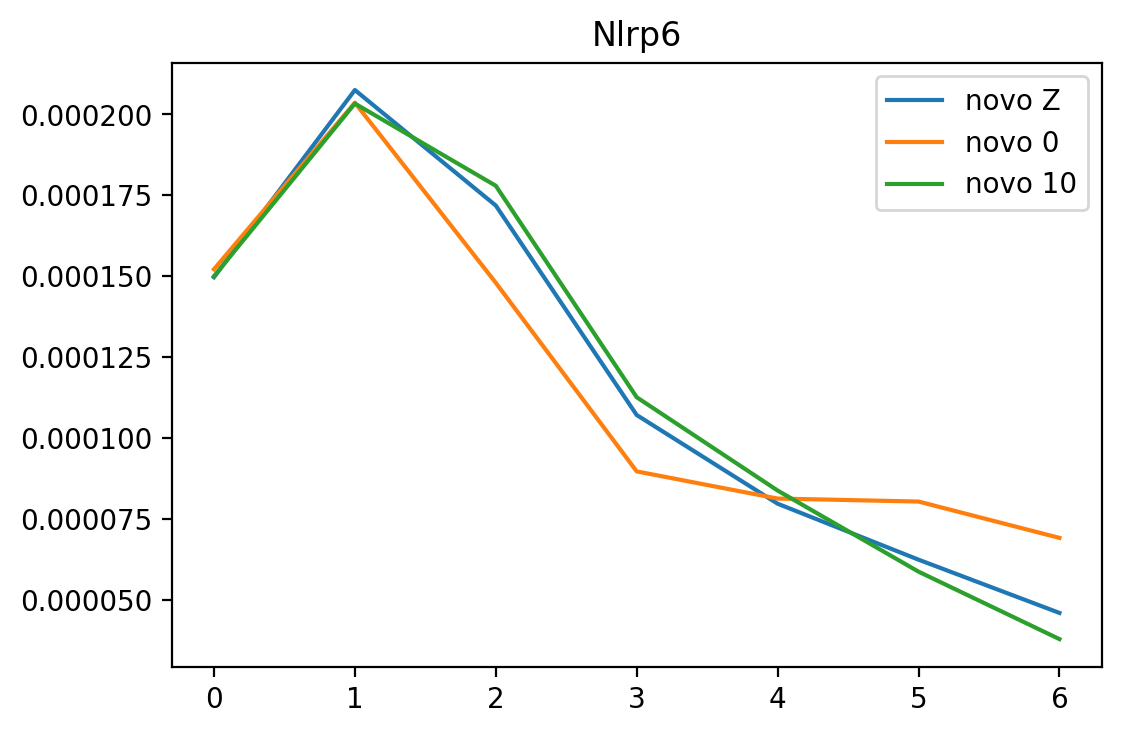

0.9176361403068548
0.8841460936134261
0.9223418700600846


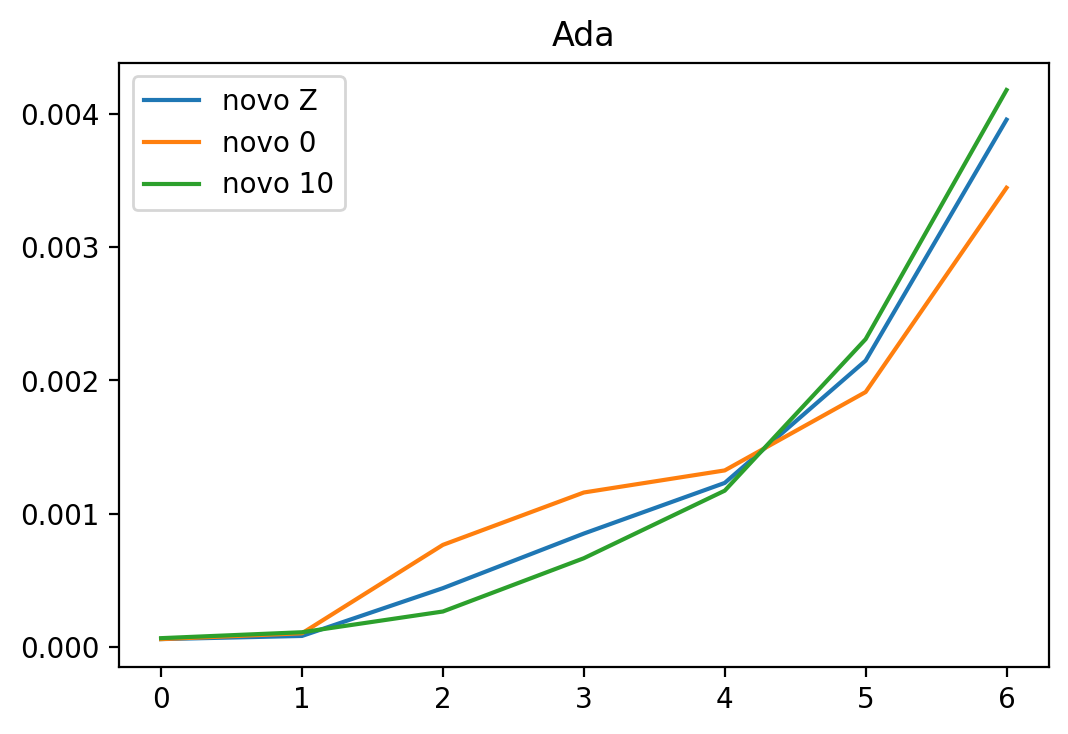

In [444]:
# plot some examples
def plot_genes(tissue_list, gene_list, dataset, dim, flip, mean_gene_ann):
    lab = ['Z', '0', '10']
    for g in gene_list:
        for t in [0, 1, 2]:
            cell_map = tissue_list[t].gw* dim
            cur_coef = []
        
            temp = dataset[:, g].X.T.dot(cell_map).T           
            temp2 = np.array([np.mean(temp[int(i * (dim/7)): int((i + 1)* (dim/7))]) for i in range(7)])

            if t in [1]:
                temp2 = np.flip(temp2)
            print(np.corrcoef(mean_gene_ann[:, g].X.T[0], temp2)[0][1])
            
            plt.plot(temp2, label = 'novo ' + lab[t])
            
#         plt.plot(mean_gene_ann[:, g].X.T[0], '--', label = 'True')
        plt.title(g)
        plt.legend()
        plt.show()
pl_genes = ['Reg3g','Tfrc', 'Pigr', 'Nlrp6', 'Ada']
plot_genes([update_tiss_z[0][0], update_tiss[0][0], update_tiss[0][8]], pl_genes, dataset, dim, True, mean_gene_ann)
